# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [11]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder,LabelBinarizer, LabelEncoder, Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import re
import ast

# magic word for producing visualizations in notebook
%matplotlib inline
pd.set_option('display.max_columns',None)

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [48]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv',delimiter = ';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv',delimiter = ';')

In [37]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
print("The dimension of demographics data is{}".format(azdias.shape))
azdias.head(10)

The dimension of demographics data is(386463, 85)


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,NaN,2.0,3.0,4.0,3.0,5.0,5.0,3.0,4.0,NaN,10.0,0,NaN,15.0,4.0,2.0,2.0,1.0,1.0,NaN,NaN,5.0,2.0,6.0,7.0,5.0,NaN,5.0,3.0,3.0,4.0,7.0,6.0,6.0,5.0,3.0,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,2.0,5.0,NaN,5.0,2.0,5.0,4.0,5.0,NaN,1996.0,10.0,0,3.0,21.0,6.0,5.0,3.0,2.0,1.0,NaN,14.0,1.0,5.0,4.0,4.0,3.0,NaN,2.0,2.0,3.0,6.0,4.0,7.0,4.0,7.0,6.0,3.0,1.0,0.0,2.0,5.0,0.0,2.0,0.0,6.0,NaN,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,5.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2.0,3.0,NaN,4.0,NaN,2.0,3.0,5.0,NaN,1979.0,10.0,1,3.0,3.0,1.0,1.0,1.0,3.0,2.0,NaN,15.0,3.0,4.0,NaN,3.0,3.0,4.0,4.0,6.0,3.0,4.0,7.0,7.0,7.0,3.0,3.0,2.0,0.0,0.0,NaN,5.0,17.0,1.0,0.0,4.0,NaN,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2.0,2.0,4.0,2.0,5.0,2.0,NaN,2.0,6.0,1957.0,1.0,0,2.0,0.0,0.0,0.0,0.0,9.0,4.0,NaN,8.0,2.0,5.0,NaN,2.0,NaN,4.0,4.0,7.0,4.0,3.0,4.0,4.0,5.0,4.0,4.0,NaN,0.0,0.0,NaN,3.0,13.0,0.0,0.0,1.0,NaN,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,1.0,4.0,4.0,2.0,6.0,4.0,0.0,4.0,1.0,0.0,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,NaN,5.0,4.0,3.0,4.0,NaN,3.0,2.0,5.0,1963.0,5.0,0,3.0,32.0,10.0,10.0,5.0,3.0,2.0,NaN,8.0,5.0,6.0,4.0,4.0,2.0,7.0,4.0,4.0,6.0,2.0,3.0,2.0,2.0,4.0,2.0,2.0,0.0,0.0,2.0,4.0,20.0,4.0,0.0,5.0,1.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,3.0,NaN,2.0,2.0,3.0,NaN,5.0,2.0,2.0,5.0,2.0,1943.0,1.0,0,3.0,8.0,2.0,1.0,1.0,4.0,2.0,NaN,3.0,3.0,2.0,4.0,7.0,4.0,2.0,2.0,2.0,5.0,7.0,4.0,4.0,4.0,7.0,6.0,0.0,0.0,0.0,2.0,4.0,10.0,1.0,0.0,5.0,3.0,6.0,9.0,5.0,0.0,1.0,5.0,1992.0,W,7.0,8,8C,54,2.0,2.0,0.0,0.0,0.0,4.0,6.0,2.0,7.0,4.0,4.0,4.0,1.0,5.0,1300.0,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,NaN,2.0,2.0,5.0,NaN,5.0,NaN,5.0,4.0,3.0,4.0,NaN,12.0,0,2.0,2.0,1.0,1.0,1.0,2.0,1.0,NaN,10.0,4.0,2.0,5.0,5.0,7.0,2.0,6.0,5.0,5.0,7.0,7.0,4.0,7.0,7.0,7.0,NaN,0.0,0.0,NaN,4.0,0.0,1.0,0.0,6.0,NaN,3.0,9.0,4.0,0.0,1.0,5.0,1992.0,W,5.0,4,4A,22,3.0,2.0,0.0,0.0,1.0,3.0,6.0,4.0,3.0,5.0,3.0,5.0,2.0,5.0,867.0,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0
7,NaN,NaN,NaN,3.0,3.0,3.0,4.0,NaN,3.0,2.0,5.0,1964.0,9.0,0,NaN,5.0,2.0,1.0,1.0,1.0,1.0,NaN,8.0,5.0,7.0,7.0,7.0,5.0,6.0,2.0,2.0,7.0,5.0,NaN,NaN,2.0,5.0,5.0,0.0,0.0,0.0,NaN,NaN,14.0,1.0,0.0,4.0,NaN,5.0,9.0,6.0,0.0,8.0,3.0,1992.0,W,1.0,2,2D,14,2.0,2.0,0.0,0.0,0.0,4.0,2.0,5.0,3.0,4.0,1.0,4.0,1.0,1.0,758.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0
8,NaN,3.0,NaN,3.0,4.0,4.0,2.0,4.0,2.0,2.0,6.0,1974.0,3.0,1,3.0,10.0,3.0,1.0,1.0,10.0,5.0,NaN,11.0,4.0,4.0,5.0,4.0,NaN,5.0,6.0,4.0,5.0,2.0,5.0,5.0,3.0,NaN,4

In [3]:
print('The dimension of features_infomation is {}'.format(feat_info.shape))
feat_info.groupby(by='missing_or_unknown').size()

The dimension of features_infomation is (85, 4)


missing_or_unknown
[-1,0,9]     1
[-1,0]      16
[-1,9]      17
[-1,XX]      1
[-1,X]       1
[-1]        26
[0]         12
[XX]         1
[]          10
dtype: int64

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [3]:
#At first, I want wo know how many data is really missing of unknown in every columns.
for col in azdias.columns:
    print(azdias[col].value_counts())

-1    294051
 2     42455
 1     34630
 3     11747
 0      3580
Name: AGER_TYP, dtype: int64
3    156042
4     98837
2     68443
1     61833
9      1308
Name: ALTERSKATEGORIE_GROB, dtype: int64
2    202071
1    184392
Name: ANREDE_KZ, dtype: int64
4.0    91187
3.0    68081
6.0    66991
2.0    64624
5.0    51025
1.0    42400
Name: CJT_GESAMTTYP, dtype: int64
3    111023
5     73598
4     72981
2     68801
1     60060
Name: FINANZ_MINIMALIST, dtype: int64
1    108199
4     86891
2     67006
5     63194
3     61173
Name: FINANZ_SPARER, dtype: int64
5    105807
3     99151
4     86886
2     50225
1     44394
Name: FINANZ_VORSORGER, dtype: int64
5    100867
1     92132
2     70137
4     61962
3     61365
Name: FINANZ_ANLEGER, dtype: int64
1    94023
5    87658
2    81558
3    73948
4    49276
Name: FINANZ_UNAUFFAELLIGER, dtype: int64
3    102687
5     78320
2     75085
4     67628
1     62743
Name: FINANZ_HAUSBAUER, dtype: int64
6    124303
1     86745
4     56726
2     48798
5     46553
3

In [30]:
# we want to know the type of the data in 'missing_or_unknown' column
for i in  range(len(feat_info['missing_or_unknown'])):
    feat_info['missing_or_unknown'][i] = feat_info['missing_or_unknown'][i].replace('XX', 'yy')
    feat_info['missing_or_unknown'][i] = feat_info['missing_or_unknown'][i].replace('X', ' \"X\" ')
    feat_info['missing_or_unknown'][i] = feat_info['missing_or_unknown'][i].replace('yy', ' \"XX\" ')
print(feat_info['missing_or_unknown'])

# Identify missing or unknown data values and convert them to NaNs.
for i in range(feat_info.shape[0]):
    missing_value = eval(feat_info.loc[i,'missing_or_unknown'])
    azdias.iloc[:,i] = azdias.iloc[:,i].apply(lambda x: np.nan if x in missing_value else x)
    azdias.iloc[:,i] = azdias.iloc[:,i].apply(lambda x: np.nan if x == '' else x)

0          [-1,0]
1        [-1,0,9]
2          [-1,0]
3             [0]
4            [-1]
5            [-1]
6            [-1]
7            [-1]
8            [-1]
9            [-1]
10           [-1]
11            [0]
12             []
13             []
14         [-1,0]
15            [0]
16            [0]
17            [0]
18            [0]
19            [0]
20            [0]
21         [-1,0]
22         [-1,0]
23            [0]
24         [-1,9]
25         [-1,9]
26         [-1,9]
27         [-1,9]
28         [-1,9]
29         [-1,9]
         ...     
55           [-1]
56           [-1]
57     [-1, "X" ]
58       [ "XX" ]
59    [-1, "XX" ]
60           [-1]
61           [-1]
62           [-1]
63           [-1]
64         [-1,0]
65         [-1,0]
66           [-1]
67           [-1]
68           [-1]
69             []
70         [-1,0]
71             []
72             []
73         [-1,0]
74             []
75           [-1]
76           [-1]
77           [-1]
78           [-1]
79        

In [31]:
azdias

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,4,NaN,10.0,0,NaN,15.0,4.0,2.0,2.0,1.0,1.0,NaN,NaN,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,1,1996.0,10.0,0,3.0,21.0,6.0,5.0,3.0,2.0,1.0,1.0,14.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3.0,1.0,NaN,2.0,5,NaN,2.0,0.0,6.0,NaN,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,5.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,1,1979.0,10.0,1,3.0,3.0,1.0,1.0,1.0,3.0,2.0,1.0,15.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2.0,0.0,NaN,1.0,5,17.0,1.0,0.0,4.0,NaN,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,NaN,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,6,1957.0,1.0,0,2.0,NaN,NaN,NaN,NaN,9.0,4.0,1.0,8.0,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1.0,0.0,NaN,1.0,3,13.0,0.0,0.0,1.0,NaN,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,1.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,5,1963.0,5.0,0,3.0,32.0,10.0,10.0,5.0,3.0,2.0,1.0,8.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2.0,0.0,NaN,2.0,4,20.0,4.0,0.0,5.0,1.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,NaN,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,3.0,1.0,2,2.0,3,1,5,2,2,5,2,1943.0,1.0,0,3.0,8.0,2.0,1.0,1.0,4.0,2.0,1.0,3.0,3.0,2,4,7,4,2,2,2,5,7,4,4,4,7,6,0.0,0.0,NaN,2.0,4,10.0,1.0,0.0,5.0,3.0,6.0,9.0,5.0,0.0,1.0,5.0,1992.0,W,7.0,8,8C,54,2.0,2.0,0.0,0.0,NaN,4.0,6.0,2.0,7.0,4.0,4.0,4.0,1.0,5.0,1300.0,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,NaN,2.0,2,5.0,1,5,1,5,4,3,4,NaN,12.0,0,2.0,2.0,1.0,1.0,1.0,2.0,1.0,1.0,10.0,4.0,2,5,5,7,2,6,5,5,7,7,4,7,7,7,1.0,0.0,NaN,1.0,4,NaN,1.0,0.0,6.0,NaN,3.0,9.0,4.0,0.0,1.0,5.0,1992.0,W,5.0,4,4A,22,3.0,2.0,0.0,0.0,1.0,3.0,6.0,4.0,3.0,5.0,3.0,5.0,2.0,5.0,867.0,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0
7,NaN,1.0,1,3.0,3,3,4,1,3,2,5,1964.0,9.0,0,1.0,5.0,2.0,1.0,1.0,1.0,1.0,1.0,8.0,5.0,7,7,7,5,6,2,2,7,5,1,1,2,5,5,0.0,0.0,NaN,1.0,1,14.0,1.0,0.0,4.0,NaN,5.0,9.0,6.0,0.0,8.0,3.0,1992.0,W,1.0,2,2D,14,2.0,2.0,0.0,0.0,NaN,4.0,2.0,5.0,3.0,4.0,1.0,4.0,1.0,1.0,758.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0
8,NaN,3.0,1,3.0,4,4,2,4,2,2,6,1974.0,3.0,1,3.0,10.0,3.0,1.0,1.0,10.0,5.0,1.0,11.0,4.0,4,5,4,1,5,6,4,5,2,5,5,3,1,4,3.0,0.0,NaN,2.0,6,16.0,1.0,0.0,3.0,NaN,5.0,8.0,2.0,1.0,3.0,4.0,1992.0,W,1.0,1,1A,13,1.0,1.0,0.0,0.0,NaN,5.0,3.0,4.0,4.0,4.0,1.0,3.0,2.0,3.0,511.0,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0
9,NaN,3.0,2,4.0,2,4,2,3,5,4,1,1975.0,12.0,1,2.0,4.0,1.0,1.0,1.0,3.0,2.0,1.0,15.0,4.0,2,1,1,3,2,6,6,3,4,7,6,7,1,3,3.0,0.0,NaN,2.0,4,17.0,1.0,0.0,4.0,6.0,4.0,3.0,9.0,0.0,3.0,4.0,1992.0,W,7.0,1,1E,15,1.0,3.0,1.0,0.0,NaN,2.0,6.

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

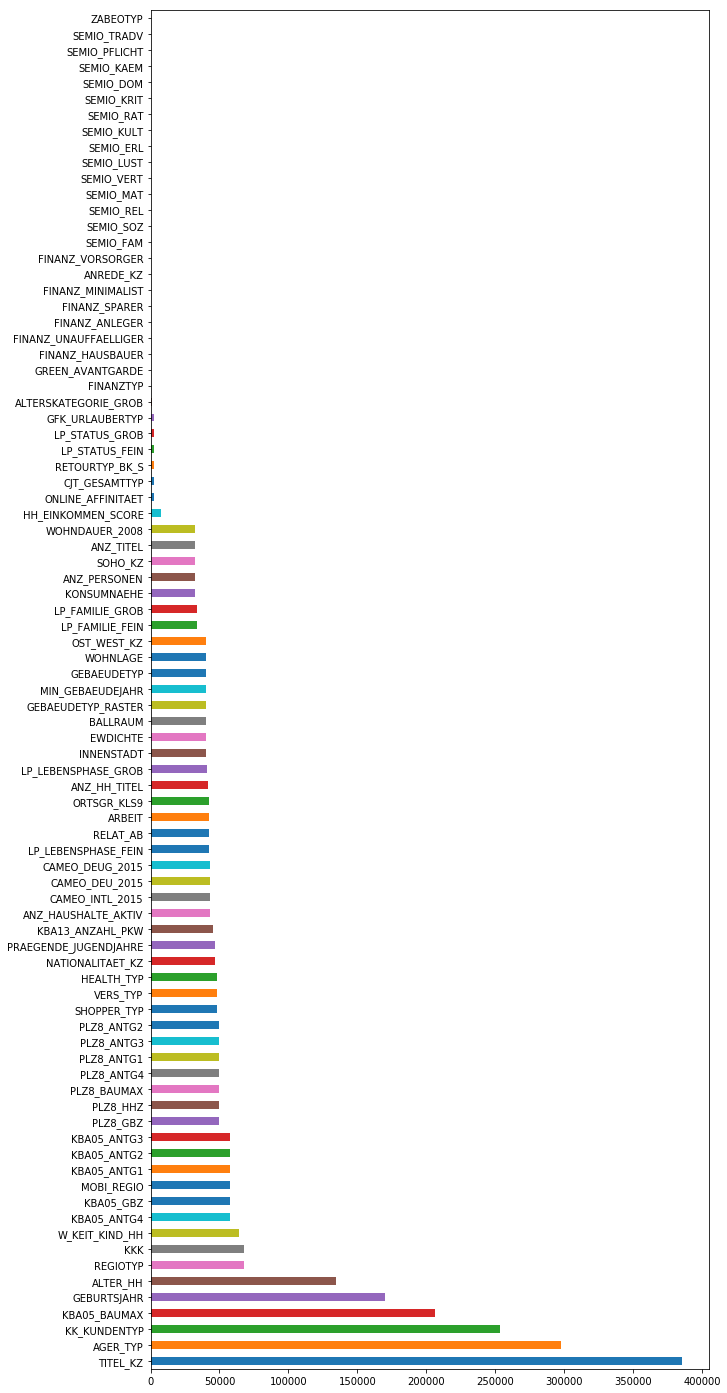

In [33]:
# Perform an assessment of how much missing data there is in each column of the
# dataset. 
#The ratio of missing data in each column
missing_data_total = azdias.isnull().sum()

# Plot showing missing value ratio in each columns
plt.figure(figsize=(10,25))
missing_data_total.sort_values(ascending=False).plot(kind='barh')

# Identifying the outlier columns
drop_columns = missing_data_total[missing_data_total>100000]

In [34]:
drop_columns.index

Index(['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP',
       'KBA05_BAUMAX'],
      dtype='object')

#### Discussion 1.1.2: Assess Missing Data in Each Column

- From the exploration ablove, I found that the missing data in each column has a wide range from 0 to 792400.After seeing the quantile and the distribution of the data ,I decide to set 175000 as the threshold to drop the columns that contains many missing values,because 133334 is the 75% quantile of our dataset.

- The dropped columns are: ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP','KBA05_BAUMAX']

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff033ef7b70>]], dtype=object)

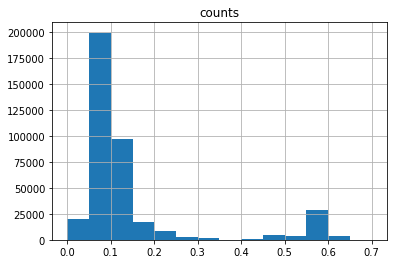

In [19]:
# The ratio of missing data in each row
missing_data_ratio_row = pd.DataFrame((azdias.shape[1]-azdias.count(axis = 1))/ azdias.shape[1])
missing_data_ratio_row.columns = ['counts']

# Plot showing missing value ratio in each row
plt.figure(figsize=(10,25))
bin_width = np.arange(0,missing_data_ratio_row.max()+0.05,0.05)
missing_data_ratio_row.sort_values(by = ['counts'],ascending=False).hist(bins = bin_width)


In [ ]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
The_nomal_row = azdias[missing_data_ratio_row<0.55]
The_outlier_row = azdias[missing_data_ratio_row>0.55]

In [53]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

#First we need to find the columns that are no or few missing values
names = list(missing_data_ratio[missing_data_ratio< 0.45].index)[0:10] #0.35 is the 25%quantile of the missing data in columns
names

['ALTERSKATEGORIE_GROB',
 'CJT_GESAMTTYP',
 'FINANZ_MINIMALIST',
 'FINANZ_SPARER',
 'FINANZ_VORSORGER',
 'FINANZ_ANLEGER',
 'FINANZ_UNAUFFAELLIGER',
 'FINANZ_HAUSBAUER',
 'FINANZTYP',
 'GEBURTSJAHR']

In [ ]:
def data_comparison(column_name):
    fig, ax =plt.subplots(1,2)
    ax1 = sns.countplot(x=column_name, data=The_nomal_row, ax=ax[0])
    ax2 = sns.countplot(x=column_name, data=The_outlier_row, ax=ax[1])
    
for col in names:
    data_comparison(col)

#### Discussion 1.1.3: Assess Missing Data in Each Row

- In this cell, I explore the missing data in rows.The same process as I do in the previous step,I observe the quantile and the distribution of data in rows.I find that the missing values also has a wide rnge from 0 to 56.I set 30 as the threshold to devide them into two subset.
- Also, I choose columns that contain few missing data and show the difference between these two subsets.I found there is a big difference between them.


### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [22]:
# How many features are there of each data type?
feat_info.type.value_counts()


ordinal        49
categorical    21
mixed           7
numeric         7
interval        1
Name: type, dtype: int64

In [23]:
feat_info

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [24]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
category_name = list(feat_info[feat_info['type']== 'categorical'].attribute)
category_col = azdias[category_name]
category_col

,AGER_TYP,ANREDE_KZ,CJT_GESAMTTYP,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,KK_KUNDENTYP,GEBAEUDETYP,OST_WEST_KZ,CAMEO_DEUG_2015,CAMEO_DEU_2015
0,NaN,NaN,2.0,4.0,10.0,0,2.0,2.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN
1,NaN,2.0,5.0,NaN,10.0,0,5.0,3.0,2.0,1.0,NaN,3.0,1.0,0.0,2.0,5.0,NaN,8.0,W,8,8A
2,NaN,2.0,3.0,NaN,10.0,1,1.0,1.0,3.0,2.0,NaN,2.0,0.0,0.0,NaN,5.0,NaN,1.0,W,4,4C
3,2.0,2.0,2.0,6.0,1.0,0,0.0,0.0,9.0,4.0,NaN,NaN,0.0,0.0,NaN,3.0,NaN,1.0,W,2,2A
4,NaN,NaN,5.0,5.0,5.0,0,10.0,5.0,3.0,2.0,NaN,2.0,0.0,0.0,2.0,4.0,1.0,1.0,W,6,6B
5,3.0,2.0,2.0,2.0,1.0,0,1.0,1.0,4.0,2.0,NaN,0.0,0.0,0.0,2.0,4.0,3.0,1.0,W,8,8C
6,NaN,2.0,5.0,4.0,12.0,0,1.0,1.0,2.0,1.0,NaN,NaN,0.0,0.0,NaN,4.0,NaN,1.0,W,4,4A
7,NaN,NaN,3.0,5.0,9.0,0,1.0,1.0,1.0,1.0,NaN,0.0,0.0,0.0,NaN,NaN,NaN,8.0,W,2,2D
8,NaN,NaN,3.0,6.0,3.0,1,1.0,1.0,10.0,5.0,NaN,3.0,0.0,0.0,2.0,6.0,NaN,3.0,W,NaN,1A
9,NaN,2.0,4.0,NaN,12.0,1,1.0,1.0,3.0,2.0,NaN,3.0,0.0,0.0,2.0,4.0,6.0,3.0,W,NaN,1E


In [25]:
#we initialize a dict to re-encode the category data
cat_dict = {}
for name, col in category_col.iteritems():
    if len(col.value_counts())== 1:
        cat_dict[name] = 'one_binary'
    elif len(col.value_counts())== 2:
        cat_dict[name] = 'binary'
    else:
        cat_dict[name] = 'multi_binary'
cat_dict


{'AGER_TYP': 'binary',
 'ANREDE_KZ': 'one_binary',
 'CJT_GESAMTTYP': 'multi_binary',
 'FINANZTYP': 'multi_binary',
 'GFK_URLAUBERTYP': 'multi_binary',
 'GREEN_AVANTGARDE': 'binary',
 'LP_FAMILIE_FEIN': 'multi_binary',
 'LP_FAMILIE_GROB': 'multi_binary',
 'LP_STATUS_FEIN': 'multi_binary',
 'LP_STATUS_GROB': 'multi_binary',
 'NATIONALITAET_KZ': 'binary',
 'SHOPPER_TYP': 'multi_binary',
 'SOHO_KZ': 'binary',
 'TITEL_KZ': 'multi_binary',
 'VERS_TYP': 'one_binary',
 'ZABEOTYP': 'multi_binary',
 'KK_KUNDENTYP': 'multi_binary',
 'GEBAEUDETYP': 'multi_binary',
 'OST_WEST_KZ': 'binary',
 'CAMEO_DEUG_2015': 'multi_binary',
 'CAMEO_DEU_2015': 'multi_binary'}

In [26]:
for key in cat_dict.keys():
    print(category_col[key].value_counts())

2.0    42455
3.0    11747
Name: AGER_TYP, dtype: int64
2.0    202071
Name: ANREDE_KZ, dtype: int64
4.0    91187
3.0    68081
6.0    66991
2.0    64624
5.0    51025
1.0    42400
Name: CJT_GESAMTTYP, dtype: int64
6.0    124303
4.0     56726
2.0     48798
5.0     46553
3.0     23338
Name: FINANZTYP, dtype: int64
12.0    59444
5.0     52088
10.0    47883
8.0     38458
11.0    34294
4.0     27481
9.0     26079
3.0     24602
1.0     23696
2.0     20094
7.0     18612
6.0     11577
Name: GFK_URLAUBERTYP, dtype: int64
0    309378
1     77085
Name: GREEN_AVANTGARDE, dtype: int64
1.0     184335
10.0     59770
2.0      45236
0.0      31776
11.0     22660
8.0      10116
7.0       9013
4.0       5335
5.0       5132
9.0       4800
6.0       3925
3.0       2210
Name: LP_FAMILIE_FEIN, dtype: int64
1.0    184335
5.0     87230
2.0     45236
0.0     31776
4.0     23054
3.0     12677
Name: LP_FAMILIE_GROB, dtype: int64
1.0     94965
9.0     62162
10.0    52105
2.0     50301
4.0     33536
5.0     32674
3.0 

In [69]:
# Re-encode categorical variable(s) to be kept in the analysis.
def encorder(dictionary, df):
    le = LabelEncoder()
    for key, value in dictionary.items():
        if key =='OST_WEST_KZ':
            df.loc[df[key]=='W',key]=0
            df.loc[df[key]=='O',key]=1
            df = pd.concat([df, pd.get_dummies(df[key],prefix= name)],axis = 1).drop([key],axis = 1)
        elif key == 'CAMEO_DEU_2015': 
            le.fit(df[key].astype(str))
            print(list(le.classes_))
            df[key] = le.transform(df[key].astype(str))
            df = pd.concat([df, pd.get_dummies(df[key],prefix= name)],axis = 1).drop([key],axis = 1) 
            print("Done")
        else:
            if value == 'multi_binary':            
                df = pd.concat([df,pd.get_dummies(df[key])],axis = 1).drop([key],axis = 1)
                print("Done!")
            elif value =='binary':
                df = pd.concat([df,pd.get_dummies(df[key])],axis = 1).drop([key],axis = 1)
                print("Done!")


In [29]:
category_col.dropna(inplace= True)


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [37]:
encorder(cat_dict, category_col)

Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
['2C', '2D', '3C', '3D', '4A', '4C', '4D', '5A', '5B', '5D', '6A', '6B', '6C', '6E', '7A', '7B', '7D', '8A', '8B', '8C', '8D', '9A', '9B', '9C', '9D', '9E']
Done


In [26]:
category_col

,AGER_TYP,ANREDE_KZ,CJT_GESAMTTYP,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,KK_KUNDENTYP,GEBAEUDETYP,OST_WEST_KZ,CAMEO_DEUG_2015,CAMEO_DEU_2015
1465,3.0,2.0,1.0,6.0,11.0,0,11.0,5.0,1.0,1.0,3.0,0.0,0.0,0.0,2.0,6.0,5.0,1.0,W,9,9D
6609,2.0,2.0,2.0,2.0,10.0,1,11.0,5.0,3.0,2.0,2.0,2.0,0.0,0.0,2.0,4.0,4.0,8.0,W,5,5A
7238,2.0,2.0,3.0,6.0,4.0,0,2.0,2.0,9.0,4.0,2.0,0.0,0.0,0.0,2.0,3.0,4.0,1.0,W,5,5B
7304,3.0,2.0,1.0,2.0,5.0,0,1.0,1.0,1.0,1.0,2.0,2.0,0.0,0.0,2.0,3.0,6.0,1.0,W,9,9D
8095,3.0,2.0,2.0,2.0,9.0,0,1.0,1.0,9.0,4.0,2.0,0.0,0.0,0.0,2.0,4.0,4.0,3.0,W,3,3D
14128,2.0,2.0,6.0,2.0,1.0,0,2.0,2.0,4.0,2.0,3.0,2.0,0.0,0.0,2.0,3.0,3.0,1.0,W,6,6C
14266,3.0,2.0,1.0,2.0,4.0,0,11.0,5.0,1.0,1.0,3.0,2.0,0.0,0.0,2.0,6.0,4.0,1.0,W,9,9A
20009,3.0,2.0,4.0,6.0,3.0,0,10.0,5.0,1.0,1.0,3.0,2.0,0.0,0.0,2.0,4.0,1.0,3.0,W,8,8B
20448,3.0,2.0,2.0,6.0,10.0,0,2.0,2.0,1.0,1.0,2.0,2.0,0.0,0.0,2.0,3.0,5.0,1.0,W,8,8A
22747,3.0,2.0,6.0,5.0,8.0,0,2.0,2.0,1.0,1.0,3.0,2.0,0.0,0.0,2.0,3.0,5.0,8.0,W,8,8B


#### Discussion 1.2.1: Re-Encode Categorical Features
- First,I create a dict to look up according to the info given by feat_info table.The binary category and the multi-category need to be encoded, while the one-binary category needn't.
- During encoding,we found that some columns couldn't be encoded because of too may nan's and that's why we drop them before encoding.After that process, we found that two columns contain string rather than number which we could't convert into array in our function.So we need to process these two columns separatly.


#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [27]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
azdias["PRAEGENDE_JUGENDJAHRE"].value_counts()

14.0    188697
8.0     145988
5.0      86416
10.0     85808
3.0      55195
15.0     42547
11.0     35752
9.0      33570
6.0      25652
12.0     24446
4.0      20451
2.0       7479
13.0      5764
7.0       4010
Name: PRAEGENDE_JUGENDJAHRE, dtype: int64

In [28]:
lookup_table ={}
with open("Data_Dictionary.md") as file:
    for f in file.readlines()[245:260]:
        lookup_table[f[1:4]]=f[5:]
for key, value in lookup_table.items():
    azdias["PRAEGENDE_JUGENDJAHRE"] = azdias["PRAEGENDE_JUGENDJAHRE"].replace(int(key),value)

In [29]:
#we compile two regular expression to extrct two new feature called "Generation" and "Nation"
azdias["Generation"] = azdias["PRAEGENDE_JUGENDJAHRE"].str.extract(r'(\d0).*')
azdias["Nation"] = azdias["PRAEGENDE_JUGENDJAHRE"].str.extract(r'\d0s\s\-\s.+\W{1}\D+\,(.{1,4}).+$')

In [30]:
azdias["Nation"]

0          NaN
1          E+W
2          E+W
3          E+W
4          E+W
5          E+W
6            W
7          E+W
8            W
9          E+W
10         E+W
11         NaN
12         E+W
13         E+W
14         NaN
15         E+W
16         E+W
17         NaN
18           W
19         E+W
20           W
21           W
22         E+W
23         E+W
24         NaN
25         E+W
26         E+W
27           W
28           W
29           W
          ... 
891191     E+W
891192     E+W
891193     E+W
891194       W
891195     E+W
891196     E+W
891197       W
891198     E+W
891199       W
891200     E+W
891201       W
891202       W
891203     NaN
891204       W
891205     E+W
891206     E+W
891207     E+W
891208     E+W
891209     E+W
891210     E+W
891211     E+W
891212     E+W
891213       W
891214     E+W
891215       W
891216     E+W
891217       W
891218     E+W
891219     E+W
891220     E+W
Name: Nation, Length: 891221, dtype: object

In [31]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
azdias["CAMEO_INTL_2015"].value_counts()


51    133694
41     92336
24     91158
14     62884
43     56672
54     45391
25     39628
22     33155
23     26750
13     26336
45     26132
55     23955
52     20542
31     19024
34     18524
15     16974
44     14820
12     13249
35     10356
32     10354
33      9935
Name: CAMEO_INTL_2015, dtype: int64

In [32]:
#The Scond Step, we pretend to write regular expression to break down them into two feature
azdias["wealth"] = azdias["CAMEO_INTL_2015"].str.extract(r'(\d)\d')
azdias["life_step"] = azdias["CAMEO_INTL_2015"].str.extract(r'\d(\d)')

In [33]:
azdias["life_step"]

0         NaN
1           1
2           4
3           2
4           3
5           4
6           2
7           4
8           3
9           5
10          1
11        NaN
12          3
13          3
14        NaN
15          1
16          1
17        NaN
18          4
19          4
20          4
21          5
22          1
23          3
24        NaN
25          3
26        NaN
27          1
28          3
29          2
         ... 
891191      4
891192      2
891193      3
891194      4
891195      5
891196      3
891197      4
891198      4
891199      1
891200      2
891201      1
891202      1
891203      5
891204      4
891205      4
891206      5
891207      1
891208      4
891209      1
891210      1
891211      1
891212      1
891213      4
891214      3
891215      1
891216      1
891217      1
891218      4
891219      1
891220      3
Name: life_step, Length: 891221, dtype: object

#### Discussion 1.2.2: Engineer Mixed-Type Features
- During the exploration of column["PRAEGENDE_JUGENDJAHRE"],we should convent the numeric value to str according to the given markdown.I create a new dictionary from this file to finish this convertion.Next, I write regular expression and create two new feature called["Generation"]and ["Nation"] from this column.
- Then I explore column["CAMEO_INTL_2015"] and found that the tenth digit number represent the wealthness of them ,the ones-digit number represent thire life-step information.So I break down this column into two new feature which we can use in later analyse.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [34]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)
mixed_name = list(feat_info[feat_info['type']== 'mixed'].attribute)
for name in mixed_name:
    if name in['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015']:
        azdias.drop(columns =name,inplace = True)
    else:
        azdias[name] = LabelEncoder().fit_transform(azdias[name])
        print(type(azdias[name]))


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


In [35]:
azdias['Nation'].fillna(azdias['Nation'].median(), inplace = True)
azdias['Nation'] = LabelEncoder().fit_transform(azdias['Nation'])

TypeError: '>' not supported between instances of 'str' and 'float'

In [43]:
type(azdias.loc[10,'Nation'])

str

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [49]:
def clean_data(data,feature):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # Firstly,convert missing value codes into NaNs according to the info given by feat_info
    
    for i in  range(len(feat_info['missing_or_unknown'])):
        feature['missing_or_unknown'][i] = feature['missing_or_unknown'][i].replace('XX', 'yy')
        feature['missing_or_unknown'][i] = feature['missing_or_unknown'][i].replace('X', ' \"X\" ')
        feature['missing_or_unknown'][i] = feature['missing_or_unknown'][i].replace('yy', ' \"XX\" ')

    for i in range(feature.shape[0]):
        missing_value = eval(feature.loc[i,'missing_or_unknown'])
        data.iloc[:,i] = data.iloc[:,i].apply(lambda x: np.nan if x in missing_value else x)
        data.iloc[:,i] = data.iloc[:,i].apply(lambda x: np.nan if x == '' else x)
    print("First Step Completed")
    
    #Secondly remove the columns and rows that contain too much Nans
    drop_azdias = data.drop(columns=['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX'])
    missing_in_row = pd.DataFrame((azdias.shape[1]-azdias.count(axis = 1))/ azdias.shape[1])
    missing_in_row.columns = ['counts']
    The_normal_row = drop_azdias[missing_in_row['counts']<= 0.45]
    print("Second Step Completed")
    
    # Thirdly, we select, re-encode, and engineer column values.
    le = LabelEncoder()
    category_name = list(feat_info[feat_info['type']== 'categorical'].attribute)
    for name in category_name:
        if name in The_normal_row.columns:
            if name == 'OST_WEST_KZ':
                The_normal_row.loc[The_normal_row[name]=='W',name]=0
                The_normal_row.loc[The_normal_row[name]=='O',name]=1
                The_normal_row = pd.concat([The_normal_row, 
                                            pd.get_dummies(The_normal_row[name],prefix= name)],axis = 1).drop([name],axis = 1) 
            elif name =='CAMEO_DEU_2015':
                le.fit(The_normal_row[name].astype(str))
                print(list(le.classes_))
                The_normal_row[name] = le.transform(The_normal_row[name].astype(str))
                The_normal_row = pd.concat([The_normal_row, 
                                            pd.get_dummies(The_normal_row[name],prefix= name)],axis = 1).drop([name],axis = 1) 
            else:
                print(name)
                The_normal_row[name].fillna(The_normal_row[name].median(), inplace = True)
                print(The_normal_row[name].isna().sum())
                The_normal_row = pd.concat([The_normal_row,
                                            pd.get_dummies(The_normal_row[name],prefix = name)],axis = 1).drop([name],axis = 1)
    print("RE-encoded process completed")  
    #dealing with mixed feature
    lookup_table ={}
    with open("Data_Dictionary.md") as file:
        for f in file.readlines()[245:260]:
            lookup_table[f[3:4]]=f[6:]
    for key, value in lookup_table.items():
        The_normal_row["PRAEGENDE_JUGENDJAHRE"] = The_normal_row["PRAEGENDE_JUGENDJAHRE"].replace(int(key),value)
    print(The_normal_row["PRAEGENDE_JUGENDJAHRE"].value_counts())
    The_normal_row["Generation"] = The_normal_row["PRAEGENDE_JUGENDJAHRE"].str.extract(r'(\d0).*')
    The_normal_row["Nation"] = The_normal_row["PRAEGENDE_JUGENDJAHRE"].str.extract(r'\d0s\s\-\s.+\W{1}\D+\,(.{1,4}).+$')
    The_normal_row["wealth"] = The_normal_row["CAMEO_INTL_2015"].str.extract(r'(\d)\d')
    The_normal_row["life_step"] = The_normal_row["CAMEO_INTL_2015"].str.extract(r'\d(\d)')
    #The_normal_row['Nation'].dropna(inplace = True)
    le.fit(The_normal_row['Nation'].astype(str))
    print(list(le.classes_))
    The_normal_row['Nation'] = le.transform(The_normal_row['Nation'].astype(str))
    The_normal_row = pd.concat([The_normal_row, 
                                pd.get_dummies(The_normal_row['Nation'],prefix = name)],axis = 1).drop(['Nation'], axis = 1)
    le.fit(The_normal_row['Generation'].astype(str))
    print(list(le.classes_))
    The_normal_row['Generation'] = le.transform(The_normal_row['Generation'].astype(str))
    The_normal_row = pd.concat([The_normal_row,
                                pd.get_dummies(The_normal_row['Generation'],prefix= name)],axis = 1).drop(['Generation'], axis = 1)
    
    mixed_name = list(feat_info[feat_info['type']== 'mixed'].attribute)
    mixed_name.remove('KBA05_BAUMAX')
    for name in mixed_name:
        if name in['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015']:
            The_normal_row.drop(columns =name,inplace = True)
        else:
            print(The_normal_row[name].dtypes)
            The_normal_row[name].fillna(The_normal_row[name].median(), inplace = True)
            The_normal_row.loc[:,name] = LabelEncoder().fit_transform(The_normal_row[name])
    

    # Return the cleaned dataframe.
    return The_normal_row
    

In [37]:
cleaned_azdias = clean_data(azdias,feat_info)

First Step Completed
First Step Completed
First Step Completed
First Step Completed
First Step Completed
First Step Completed
First Step Completed
First Step Completed
First Step Completed
First Step Completed
First Step Completed
First Step Completed
First Step Completed
First Step Completed
First Step Completed
First Step Completed
First Step Completed
First Step Completed
First Step Completed
First Step Completed
First Step Completed
First Step Completed
First Step Completed
First Step Completed
First Step Completed
First Step Completed
First Step Completed
First Step Completed
First Step Completed
First Step Completed
First Step Completed
First Step Completed
First Step Completed
First Step Completed
First Step Completed
First Step Completed
First Step Completed
First Step Completed
First Step Completed
First Step Completed
First Step Completed
First Step Completed
First Step Completed
First Step Completed
First Step Completed
First Step Completed
First Step Completed
First Step Co

/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:5434: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


CJT_GESAMTTYP
0
FINANZTYP
0
GFK_URLAUBERTYP
0
GREEN_AVANTGARDE
0
LP_FAMILIE_FEIN
0
LP_FAMILIE_GROB
0
LP_STATUS_FEIN
0
LP_STATUS_GROB
0
NATIONALITAET_KZ
0
SHOPPER_TYP
0
SOHO_KZ
0
VERS_TYP
0
ZABEOTYP
0
GEBAEUDETYP
0
CAMEO_DEUG_2015
0
['1A', '1B', '1C', '1D', '1E', '2A', '2B', '2C', '2D', '3A', '3B', '3C', '3D', '4A', '4B', '4C', '4D', '4E', '5A', '5B', '5C', '5D', '5E', '5F', '6A', '6B', '6C', '6D', '6E', '6F', '7A', '7B', '7C', '7D', '7E', '8A', '8B', '8C', '8D', '9A', '9B', '9C', '9D', '9E', 'nan']
RE-encoded process completed
14.0                                                                80303
70s - family orientation (Mainstream, E+W)\n                        62775
10.0                                                                37870
90s - ecological awareness (Avantgarde, E+W)\n                      37422
80s - Swords into ploughshares (Avantgarde, E)\n                    23540
15.0                                                                18851
11.0                   

In [38]:
cleaned_azdias

,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,WOHNLAGE,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,ANREDE_KZ_1,ANREDE_KZ_2,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,FINANZTYP_1,FINANZTYP_2,FINANZTYP_3,FINANZTYP_4,FINANZTYP_5,FINANZTYP_6,GFK_URLAUBERTYP_1.0,GFK_URLAUBERTYP_2.0,GFK_URLAUBERTYP_3.0,GFK_URLAUBERTYP_4.0,GFK_URLAUBERTYP_5.0,GFK_URLAUBERTYP_6.0,GFK_URLAUBERTYP_7.0,GFK_URLAUBERTYP_8.0,GFK_URLAUBERTYP_9.0,GFK_URLAUBERTYP_10.0,GFK_URLAUBERTYP_11.0,GFK_URLAUBERTYP_12.0,GREEN_AVANTGARDE_0,GREEN_AVANTGARDE_1,LP_FAMILIE_FEIN_1.0,LP_FAMILIE_FEIN_2.0,LP_FAMILIE_FEIN_3.0,LP_FAMILIE_FEIN_4.0,LP_FAMILIE_FEIN_5.0,LP_FAMILIE_FEIN_6.0,LP_FAMILIE_FEIN_7.0,LP_FAMILIE_FEIN_8.0,LP_FAMILIE_FEIN_9.0,LP_FAMILIE_FEIN_10.0,LP_FAMILIE_FEIN_11.0,LP_FAMILIE_GROB_1.0,LP_FAMILIE_GROB_2.0,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0,LP_STATUS_FEIN_1.0,LP_STATUS_FEIN_2.0,LP_STATUS_FEIN_3.0,LP_STATUS_FEIN_4.0,LP_STATUS_FEIN_5.0,LP_STATUS_FEIN_6.0,LP_STATUS_FEIN_7.0,LP_STATUS_FEIN_8.0,LP_STATUS_FEIN_9.0,LP_STATUS_FEIN_10.0,LP_STATUS_GROB_1.0,LP_STATUS_GROB_2.0,LP_STATUS_GROB_3.0,LP_STATUS_GROB_4.0,LP_STATUS_GROB_5.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,SOHO_KZ_0.0,SOHO_KZ_1.0,VERS_TYP_1.0,VERS_TYP_2.0,ZABEOTYP_1,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6,GEBAEUDETYP_1.0,GEBAEUDETYP_2.0,GEBAEUDETYP_3.0,GEBAEUDETYP_4.0,GEBAEUDETYP_6.0,GEBAEUDETYP_8.0,OST_WEST_KZ_0,OST_WEST_KZ_1,CAMEO_DEUG_2015_6.0,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,CAMEO_DEU_2015_0,CAMEO_DEU_2015_1,CAMEO_DEU_2015_2,CAMEO_DEU_2015_3,CAMEO_DEU_2015_4,CAMEO_DEU_2015_5,CAMEO_DEU_2015_6,CAMEO_DEU_2015_7,CAMEO_DEU_2015_8,CAMEO_DEU_2015_9,CAMEO_DEU_2015_10,CAMEO_DEU_2015_11,CAMEO_DEU_2015_12,CAMEO_DEU_2015_13,CAMEO_DEU_2015_14,CAMEO_DEU_2015_15,CAMEO_DEU_2015_16,CAMEO_DEU_2015_17,CAMEO_DEU_2015_18,CAMEO_DEU_2015_19,CAMEO_DEU_2015_20,CAMEO_DEU_2015_21,CAMEO_DEU_2015_22,CAMEO_DEU_2015_23,CAMEO_DEU_2015_24,CAMEO_DEU_2015_25,CAMEO_DEU_2015_26,CAMEO_DEU_2015_27,CAMEO_DEU_2015_28,CAMEO_DEU_2015_29,CAMEO_DEU_2015_30,CAMEO_DEU_2015_31,CAMEO_DEU_2015_32,CAMEO_DEU_2015_33,CAMEO_DEU_2015_34,CAMEO_DEU_2015_35,CAMEO_DEU_2015_36,CAMEO_DEU_2015_37,CAMEO_DEU_2015_38,CAMEO_DEU_2015_39,CAMEO_DEU_2015_40,CAMEO_DEU_2015_41,CAMEO_DEU_2015_42,CAMEO_DEU_2015_43,CAMEO_DEU_2015_44,wealth,life_step,CAMEO_DEU_2015_0,CAMEO_DEU_2015_1,CAMEO_DEU_2015_2,CAMEO_DEU_2015_3,CAMEO_DEU_2015_0,CAMEO_DEU_2015_1,CAMEO_DEU_2015_2,CAMEO_DEU_2015_3,CAMEO_DEU_2015_4
1,1.0,1,5,2,5,4,5,3.0,20,5,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,2.0,0.0,6.0,3.0,9.0,11.0,0.0,1.0,1992.0,4,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,0,5.0,4.0,3.0,5.0,4.0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,5,1,0,0,0,1,0,0,0,0,1
2,3.0,1,4,1,2,3,5,3.0,2,0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,1.0,0.0,4.0,3.0,9.0,10.0,0.0,5.0,1992.0,2,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [40]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
copy_azdias = pd.DataFrame(data = Imputer(strategy='most_frequent').fit_transform(cleaned_azdias),columns= cleaned_azdias.columns)
copy_azdias

,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,WOHNLAGE,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,ANREDE_KZ_1,ANREDE_KZ_2,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,FINANZTYP_1,FINANZTYP_2,FINANZTYP_3,FINANZTYP_4,FINANZTYP_5,FINANZTYP_6,GFK_URLAUBERTYP_1.0,GFK_URLAUBERTYP_2.0,GFK_URLAUBERTYP_3.0,GFK_URLAUBERTYP_4.0,GFK_URLAUBERTYP_5.0,GFK_URLAUBERTYP_6.0,GFK_URLAUBERTYP_7.0,GFK_URLAUBERTYP_8.0,GFK_URLAUBERTYP_9.0,GFK_URLAUBERTYP_10.0,GFK_URLAUBERTYP_11.0,GFK_URLAUBERTYP_12.0,GREEN_AVANTGARDE_0,GREEN_AVANTGARDE_1,LP_FAMILIE_FEIN_1.0,LP_FAMILIE_FEIN_2.0,LP_FAMILIE_FEIN_3.0,LP_FAMILIE_FEIN_4.0,LP_FAMILIE_FEIN_5.0,LP_FAMILIE_FEIN_6.0,LP_FAMILIE_FEIN_7.0,LP_FAMILIE_FEIN_8.0,LP_FAMILIE_FEIN_9.0,LP_FAMILIE_FEIN_10.0,LP_FAMILIE_FEIN_11.0,LP_FAMILIE_GROB_1.0,LP_FAMILIE_GROB_2.0,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0,LP_STATUS_FEIN_1.0,LP_STATUS_FEIN_2.0,LP_STATUS_FEIN_3.0,LP_STATUS_FEIN_4.0,LP_STATUS_FEIN_5.0,LP_STATUS_FEIN_6.0,LP_STATUS_FEIN_7.0,LP_STATUS_FEIN_8.0,LP_STATUS_FEIN_9.0,LP_STATUS_FEIN_10.0,LP_STATUS_GROB_1.0,LP_STATUS_GROB_2.0,LP_STATUS_GROB_3.0,LP_STATUS_GROB_4.0,LP_STATUS_GROB_5.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,SOHO_KZ_0.0,SOHO_KZ_1.0,VERS_TYP_1.0,VERS_TYP_2.0,ZABEOTYP_1,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6,GEBAEUDETYP_1.0,GEBAEUDETYP_2.0,GEBAEUDETYP_3.0,GEBAEUDETYP_4.0,GEBAEUDETYP_6.0,GEBAEUDETYP_8.0,OST_WEST_KZ_0,OST_WEST_KZ_1,CAMEO_DEUG_2015_6.0,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,CAMEO_DEU_2015_0,CAMEO_DEU_2015_1,CAMEO_DEU_2015_2,CAMEO_DEU_2015_3,CAMEO_DEU_2015_4,CAMEO_DEU_2015_5,CAMEO_DEU_2015_6,CAMEO_DEU_2015_7,CAMEO_DEU_2015_8,CAMEO_DEU_2015_9,CAMEO_DEU_2015_10,CAMEO_DEU_2015_11,CAMEO_DEU_2015_12,CAMEO_DEU_2015_13,CAMEO_DEU_2015_14,CAMEO_DEU_2015_15,CAMEO_DEU_2015_16,CAMEO_DEU_2015_17,CAMEO_DEU_2015_18,CAMEO_DEU_2015_19,CAMEO_DEU_2015_20,CAMEO_DEU_2015_21,CAMEO_DEU_2015_22,CAMEO_DEU_2015_23,CAMEO_DEU_2015_24,CAMEO_DEU_2015_25,CAMEO_DEU_2015_26,CAMEO_DEU_2015_27,CAMEO_DEU_2015_28,CAMEO_DEU_2015_29,CAMEO_DEU_2015_30,CAMEO_DEU_2015_31,CAMEO_DEU_2015_32,CAMEO_DEU_2015_33,CAMEO_DEU_2015_34,CAMEO_DEU_2015_35,CAMEO_DEU_2015_36,CAMEO_DEU_2015_37,CAMEO_DEU_2015_38,CAMEO_DEU_2015_39,CAMEO_DEU_2015_40,CAMEO_DEU_2015_41,CAMEO_DEU_2015_42,CAMEO_DEU_2015_43,CAMEO_DEU_2015_44,wealth,life_step,CAMEO_DEU_2015_0,CAMEO_DEU_2015_1,CAMEO_DEU_2015_2,CAMEO_DEU_2015_3,CAMEO_DEU_2015_0,CAMEO_DEU_2015_1,CAMEO_DEU_2015_2,CAMEO_DEU_2015_3,CAMEO_DEU_2015_4
0,1.0,1.0,5.0,2.0,5.0,4.0,5.0,3.0,20.0,5.0,1.0,5.0,4.0,4.0,3.0,1.0,2.0,2.0,3.0,6.0,4.0,7.0,4.0,7.0,6.0,2.0,0.0,6.0,3.0,9.0,11.0,0.0,1.0,1992.0,4.0,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,0.0,5.0,4.0,3.0,5.0,4.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0

In [50]:
copy_azdias.dtypes.value_counts()

float64    199
dtype: int64

In [41]:
# Apply feature scaling to the general population demographics data.
for name, col in copy_azdias.iteritems():
    copy_azdias[name] = StandardScaler().fit_transform(X = col.values.reshape(-1,1))
copy_azdias

,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,WOHNLAGE,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,ANREDE_KZ_1,ANREDE_KZ_2,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,FINANZTYP_1,FINANZTYP_2,FINANZTYP_3,FINANZTYP_4,FINANZTYP_5,FINANZTYP_6,GFK_URLAUBERTYP_1.0,GFK_URLAUBERTYP_2.0,GFK_URLAUBERTYP_3.0,GFK_URLAUBERTYP_4.0,GFK_URLAUBERTYP_5.0,GFK_URLAUBERTYP_6.0,GFK_URLAUBERTYP_7.0,GFK_URLAUBERTYP_8.0,GFK_URLAUBERTYP_9.0,GFK_URLAUBERTYP_10.0,GFK_URLAUBERTYP_11.0,GFK_URLAUBERTYP_12.0,GREEN_AVANTGARDE_0,GREEN_AVANTGARDE_1,LP_FAMILIE_FEIN_1.0,LP_FAMILIE_FEIN_2.0,LP_FAMILIE_FEIN_3.0,LP_FAMILIE_FEIN_4.0,LP_FAMILIE_FEIN_5.0,LP_FAMILIE_FEIN_6.0,LP_FAMILIE_FEIN_7.0,LP_FAMILIE_FEIN_8.0,LP_FAMILIE_FEIN_9.0,LP_FAMILIE_FEIN_10.0,LP_FAMILIE_FEIN_11.0,LP_FAMILIE_GROB_1.0,LP_FAMILIE_GROB_2.0,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0,LP_STATUS_FEIN_1.0,LP_STATUS_FEIN_2.0,LP_STATUS_FEIN_3.0,LP_STATUS_FEIN_4.0,LP_STATUS_FEIN_5.0,LP_STATUS_FEIN_6.0,LP_STATUS_FEIN_7.0,LP_STATUS_FEIN_8.0,LP_STATUS_FEIN_9.0,LP_STATUS_FEIN_10.0,LP_STATUS_GROB_1.0,LP_STATUS_GROB_2.0,LP_STATUS_GROB_3.0,LP_STATUS_GROB_4.0,LP_STATUS_GROB_5.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,SOHO_KZ_0.0,SOHO_KZ_1.0,VERS_TYP_1.0,VERS_TYP_2.0,ZABEOTYP_1,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6,GEBAEUDETYP_1.0,GEBAEUDETYP_2.0,GEBAEUDETYP_3.0,GEBAEUDETYP_4.0,GEBAEUDETYP_6.0,GEBAEUDETYP_8.0,OST_WEST_KZ_0,OST_WEST_KZ_1,CAMEO_DEUG_2015_6.0,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,CAMEO_DEU_2015_0,CAMEO_DEU_2015_1,CAMEO_DEU_2015_2,CAMEO_DEU_2015_3,CAMEO_DEU_2015_4,CAMEO_DEU_2015_5,CAMEO_DEU_2015_6,CAMEO_DEU_2015_7,CAMEO_DEU_2015_8,CAMEO_DEU_2015_9,CAMEO_DEU_2015_10,CAMEO_DEU_2015_11,CAMEO_DEU_2015_12,CAMEO_DEU_2015_13,CAMEO_DEU_2015_14,CAMEO_DEU_2015_15,CAMEO_DEU_2015_16,CAMEO_DEU_2015_17,CAMEO_DEU_2015_18,CAMEO_DEU_2015_19,CAMEO_DEU_2015_20,CAMEO_DEU_2015_21,CAMEO_DEU_2015_22,CAMEO_DEU_2015_23,CAMEO_DEU_2015_24,CAMEO_DEU_2015_25,CAMEO_DEU_2015_26,CAMEO_DEU_2015_27,CAMEO_DEU_2015_28,CAMEO_DEU_2015_29,CAMEO_DEU_2015_30,CAMEO_DEU_2015_31,CAMEO_DEU_2015_32,CAMEO_DEU_2015_33,CAMEO_DEU_2015_34,CAMEO_DEU_2015_35,CAMEO_DEU_2015_36,CAMEO_DEU_2015_37,CAMEO_DEU_2015_38,CAMEO_DEU_2015_39,CAMEO_DEU_2015_40,CAMEO_DEU_2015_41,CAMEO_DEU_2015_42,CAMEO_DEU_2015_43,CAMEO_DEU_2015_44,wealth,life_step,CAMEO_DEU_2015_0,CAMEO_DEU_2015_1,CAMEO_DEU_2015_2,CAMEO_DEU_2015_3,CAMEO_DEU_2015_0,CAMEO_DEU_2015_1,CAMEO_DEU_2015_2,CAMEO_DEU_2015_3,CAMEO_DEU_2015_4
0,-1.767331,-1.508941,1.543622,-1.055240,1.469009,0.940642,1.362955,1.016089,-0.219579,-0.213778,-1.682822,0.451360,-0.056576,0.006036,-0.467514,-1.686909,-1.103692,-1.435385,-0.570449,1.275572,-0.316484,1.336816,-0.162046,1.527975,1.289771,0.226731,-0.060939,1.017553,-0.726673,0.566549,0.180831,-0.127992,-1.303000,-0.376904,-0.101312,-1.003463,-0.957904,-0.585552,2.768295,-1.677748,0.837853,-0.567016,1.710870,-0.813609,-0.796186,-1.266042,0.159890,-0.893634,0.884874,-0.266062,0.207502,0.409393,0.465730,-0.178718,1.466875,0.571358,-0.166994,-0.125149,0.688527,-0.956091,0.956091,-0.362078,-0.463839,-0.477200,-0.583552,2.483441,-0

### Discussion 2.1: Apply Feature Scaling

- In our dataset, there are mainly columns which types are numeric and categorical.However, their values are not in the same interval.So, I decide to rescale them into the same interval and standardlize them so that our algorithm can better recognize.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [42]:
# Apply PCA to the data.
pca = PCA()
pca.fit(copy_azdias)


PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

[  7.03335047e-02   4.31832836e-02   2.62530643e-02   2.44354330e-02
   1.96418297e-02   1.68984069e-02   1.64467210e-02   1.48703587e-02
   1.45620643e-02   1.43532088e-02   1.42671005e-02   1.35929113e-02
   1.32106942e-02   1.23998154e-02   1.22111159e-02   1.12189062e-02
   1.10457396e-02   1.09287686e-02   1.07872147e-02   1.07357224e-02
   1.05514759e-02   1.03341653e-02   1.02390207e-02   1.01785890e-02
   9.97674703e-03   9.85832181e-03   9.66110397e-03   9.57752487e-03
   9.49376599e-03   8.93322124e-03   8.69521325e-03   8.46727214e-03
   8.13271193e-03   7.93303375e-03   7.84015873e-03   7.12684223e-03
   6.79649870e-03   6.71709999e-03   6.58642133e-03   6.38395574e-03
   6.20379288e-03   6.15344207e-03   6.12764318e-03   5.99133893e-03
   5.89424460e-03   5.78073841e-03   5.72323718e-03   5.57993102e-03
   5.50746042e-03   5.42503910e-03   5.40160176e-03   5.31946714e-03
   5.30294120e-03   5.24885254e-03   5.19755590e-03   5.14315071e-03
   5.08777703e-03   5.06688869e-03

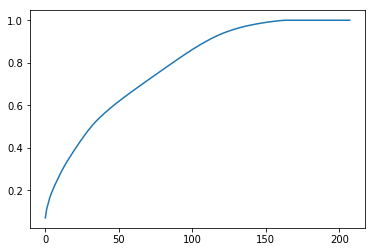

In [31]:
# Investigate the variance accounted for by each principal component.
print(pca.explained_variance_ratio_)
CDF = []
CDF.append(1)
for i in range(len(pca.explained_variance_ratio_)):
    if i == 0:
        CDF[i]= pca.explained_variance_ratio_[i]
    else:
        CDF.append(CDF[i-1] + pca.explained_variance_ratio_[i])
    
plt.plot(CDF)


In [43]:
# Re-apply PCA to the data while selecting for number of components to retain.
#From the CDF plot above and the elbow Method, I decide to choose n_component = 30
pca_80 = PCA(n_components= 80)
pca_80.fit(copy_azdias)
reduced_azdias = pca_80.transform(copy_azdias)


In [49]:
pca_80.components_[0]

array([ -4.71521229e-02,  -1.66306770e-01,   8.75812046e-02,
        -3.72762008e-02,   2.37605283e-02,   3.16008741e-02,
         4.38468120e-02,  -3.45232464e-04,  -1.51233531e-01,
        -1.38807255e-01,   1.40714143e-02,   2.61688297e-02,
         4.40390283e-02,   6.28811895e-02,   1.73551063e-02,
        -3.14909245e-02,  -8.35365100e-03,  -2.86233024e-02,
         3.98038108e-02,   4.26254467e-02,   1.02045209e-02,
         1.57422166e-02,   2.89791405e-02,   6.76162569e-02,
         2.78553185e-02,  -1.04962277e-01,  -4.41773927e-03,
         1.86881090e-01,   5.87116703e-02,  -5.00023267e-02,
         1.18174772e-01,   2.98561033e-02,  -1.38912661e-01,
        -4.90668729e-02,  -5.01287395e-02,  -1.96251962e-01,
         1.20413406e-02,   1.17289520e-01,   1.32049274e-01,
        -1.87894278e-01,  -9.96205299e-02,   1.58066884e-01,
        -1.31343243e-01,  -9.80930676e-02,   5.04165911e-02,
        -2.09819211e-01,  -7.79743410e-02,   7.09481735e-02,
        -6.33428629e-02,

### Discussion 2.2: Perform Dimensionality Reduction

- In this section, I used the pca from sklearn to perform dimension reduction on the dataset that we cleaned.We use the contribution from the principle components to draw a CDF and set parameter n_components = 100 to retain 80% information from previous dataset. 

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [50]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
def components_analyse(score, original_data,n_th):
    '''
    score is the result of PCA algorithm
    original_data is the input data
    n_th is the n_th component we plan to analyse
    '''
    df = pd.DataFrame(data = score[n_th],index = original_data.columns, columns = ['ratio']).sort_values(by = 'ratio',
                                                                                                        ascending = False)
    return df
    



In [51]:
components_analyse(pca_80.components_, copy_azdias, 0)

,ratio
LP_STATUS_GROB_1.0,0.193220
wealth,0.189594
HH_EINKOMMEN_SCORE,0.186881
PLZ8_ANTG3,0.186736
PLZ8_ANTG4,0.179777
ORTSGR_KLS9,0.159374
EWDICHTE,0.158067
LP_STATUS_FEIN_1.0,0.139448
KBA05_ANTG4,0.132049
PLZ8_ANTG2,0.129499


In [52]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
components_analyse(pca_80.components_, copy_azdias, 1)


,ratio
FINANZ_SPARER,0.252208
SEMIO_PFLICHT,0.245724
FINANZ_UNAUFFAELLIGER,0.236604
SEMIO_REL,0.234696
FINANZ_ANLEGER,0.225655
SEMIO_TRADV,0.210418
SEMIO_RAT,0.201825
ONLINE_AFFINITAET,0.173170
ZABEOTYP_4.0,0.151700
SEMIO_FAM,0.151210


In [53]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
components_analyse(pca_80.components_, copy_azdias, 2)


,ratio
GREEN_AVANTGARDE_1,0.226756
ORTSGR_KLS9,0.211109
LP_LEBENSPHASE_GROB,0.209104
EWDICHTE,0.208788
LP_LEBENSPHASE_FEIN,0.207349
LP_STATUS_FEIN_10.0,0.191151
LP_STATUS_GROB_5.0,0.191151
ANZ_PERSONEN,0.188265
LP_FAMILIE_GROB_5.0,0.181786
LP_FAMILIE_FEIN_10.0,0.136740


### Discussion 2.3: Interpret Principal Components

- PC_1 is about  the larger family capacity based on the features of LP_STATUS_GROB_1, PLZ8_ANTG3,wealth,PLZ8_ANTG4 and HH_EINKOMMEN. In contrast, some strong negative feature weights are FINANZ_MINIMALIST, KBA05_GBZ, PLZ8_ANTG1,KBA05_ANTG1 and MOBI_REGIO, which indicate the prevalence of buildings with smaller family capacity . This suggests that this feature says something about  the size of the family.
- PC_2 is about finanical technologyand personality. some strong negative feature weights are FINANZ_SPARER,SEMIO_PFLICHT,FINANZ_ANLEGER,SEMIO_REL and FINANZ_UNAUFFAELLIGER.
- PC_3 is about age   based on the feature of GREEN_AVANTGARDE_1,LP_LEBENSPHASE_GROB,LP_LEBENSPHASE_FEIN, and ORTSGR_KLS9. Some strong negative features are LP_FAMILIE_FEIN_1.0,LP_FAMILIE_GROB_1.0 and	GREEN_AVANTGARDE_0. which indicate more conservative  personality.This suggests that this feature says something about life stage.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [11]:
# Over a number of different cluster counts...
# run k-means clustering on the data and...
# compute the average within-cluster distances.
K_means = KMeans(n_clusters= 10,init='k-means++', random_state= 40)
K_means.fit(reduced_azdias).score   
    

<bound method KMeans.score of KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=40, tol=0.0001, verbose=0)>

In [12]:
def with_in_score(obj,df,n_clu):
    score_dict = {}
    score = pd.DataFrame(data = obj.labels_, columns=['label'])
    for i in range(0,n_clu):
        index = list(score[score['label']== i].index)
        score_dict[i] = obj.score(df[index])
        print("Done")
    score_dict[n_clu] = obj.score(df)
    return score_dict

In [13]:
with_in_score(K_means,reduced_azdias,10)

Done
Done
Done
Done
Done
Done
Done
Done
Done
Done


{0: -5815396.9003717583,
 1: -2462406.3288114229,
 2: -5995655.5548806852,
 3: -5304253.0270644901,
 4: -5417393.5018826472,
 5: -717310.41775178618,
 6: -332904.86546130036,
 7: -4523750.5165502047,
 8: -4771601.8549747113,
 9: -340769.47680418508,
 10: -35681442.444553196}

In [55]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
score = []
for i in range(1,50):
    k_means = KMeans(n_clusters= i ,init = 'k-means++',random_state= 1)
    k_means.fit(reduced_azdias)   
    score.append(k_means.inertia_)
    print("Done!")

Done!
Done!


KeyboardInterrupt: 

<function matplotlib.pyplot.show(*args, **kw)>

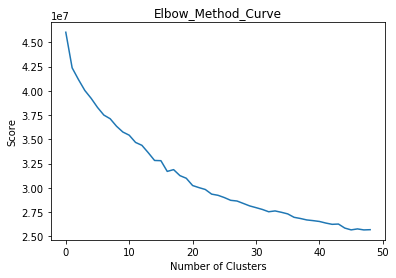

In [16]:
plt.plot(score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow_Method_Curve')
plt.show

In [44]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
k_means = KMeans(n_clusters = 5, init = 'k-means++', random_state = 42)
k_means.fit(reduced_azdias)
label = k_means.predict(reduced_azdias)


### Discussion 3.1: Apply Clustering to General Population

- In this section,we apply kmeans algorithm to our reduced dataset and collect the score from several iteration.Then,we  use the Elbow Method find that when the cluster = 15，has better performance.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [45]:
# Load in the customer demographics data.
customers = pd.read_csv("Udacity_CUSTOMERS_Subset.csv",delimiter =';')
customers.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,2,0,4.0,1,1,20.0,5.0,2.0,2.0,10.0,5.0,1,4,5.0,6,5,2,6,6,7,3,4,1,3,1,1,2,1,3,0.0,0.0,1,3,10.0,2.0,0.0,1.0,NaN,6.0,9.0,1.0,0.0,1.0,5.0,1992.0,W,7.0,1,1A,13,2.0,2.0,0.0,0.0,0.0,4.0,3.0,2.0,4.0,4.0,1.0,4.0,3.0,1.0,1201.0,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,2,0,NaN,0,1,NaN,NaN,NaN,NaN,NaN,NaN,1,0,NaN,3,6,2,6,7,5,3,4,1,3,3,2,4,1,3,0.0,0.0,1,3,11.0,3.0,0.0,NaN,NaN,0.0,9.0,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,2,0,3.0,1,2,13.0,3.0,1.0,1.0,10.0,5.0,1,4,5.0,2,2,1,3,3,7,7,1,2,7,5,6,4,1,1,0.0,0.0,2,3,6.0,1.0,0.0,1.0,NaN,6.0,9.0,1.0,0.0,8.0,1.0,1992.0,W,2.0,5,5D,34,2.0,2.0,0.0,0.0,0.0,3.0,7.0,4.0,1.0,3.0,3.0,3.0,1.0,7.0,433.0,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,6,0,10.0,0,2,0.0,0.0,0.0,0.0,9.0,4.0,1,1,3.0,6,5,3,4,7,5,3,4,3,3,3,3,3,4,0,0.0,0.0,1,1,8.0,0.0,0.0,4.0,NaN,NaN,9.0,0.0,NaN,2.0,2.0,1992.0,W,7.0,4,4C,24,3.0,0.0,0.0,0.0,1.0,4.0,7.0,1.0,7.0,4.0,3.0,4.0,2.0,6.0,755.0,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,2,1960,2.0,0,3,31.0,10.0,10.0,5.0,1.0,1.0,1,8,5.0,4,5,4,6,5,6,4,5,5,3,5,2,5,4,1,0.0,0.0,2,1,20.0,4.0,0.0,6.0,2.0,2.0,9.0,7.0,0.0,3.0,1.0,1992.0,W,3.0,7,7B,41,0.0,3.0,2.0,0.0,0.0,3.0,3.0,4.0,4.0,3.0,4.0,3.0,5.0,7.0,513.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


In [50]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
cleaned_customers = clean_data(customers, feat_info)
copy_customers = pd.DataFrame(data = Imputer(strategy='most_frequent').fit_transform(cleaned_customers),columns= cleaned_customers.columns)
for name, col in copy_customers.iteritems():
    copy_customers[name] = StandardScaler().fit_transform(X = col.values.reshape(-1,1))
reduced_customers = pca_80.transform(copy_customers)
customer_label = k_means.predict(reduced_customers)


First Step Completed


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Second Step Completed
ANREDE_KZ


/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:5434: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


0
CJT_GESAMTTYP
0
FINANZTYP
0
GFK_URLAUBERTYP
0
GREEN_AVANTGARDE
0
LP_FAMILIE_FEIN
0
LP_FAMILIE_GROB
0
LP_STATUS_FEIN
0
LP_STATUS_GROB
0
NATIONALITAET_KZ
0
SHOPPER_TYP
0
SOHO_KZ
0
VERS_TYP
0
ZABEOTYP
0
GEBAEUDETYP
0
CAMEO_DEUG_2015
0
['1A', '1B', '1C', '1D', '1E', '2A', '2B', '2C', '2D', '3A', '3B', '3C', '3D', '4A', '4B', '4C', '4D', '4E', '5A', '5B', '5C', '5D', '5E', '5F', '6A', '6B', '6C', '6D', '6E', '6F', '7A', '7B', '7C', '7D', '7E', '8A', '8B', '8C', '8D', '9A', '9B', '9C', '9D', '9E', 'nan']
RE-encoded process completed
90s - digital media kids (Mainstream, E+W)\n                        20330
80s - Swords into ploughshares (Avantgarde, E)\n                    18727
90s - ecological awareness (Avantgarde, E+W)\n                      16305
60s - generation 68 / student protestors (Avantgarde, W)\n          14147
70s - family orientation (Mainstream, E+W)\n                        13682
80s - FDJ / communist party youth organisation (Mainstream, E)\n    10405
70s - peace movement 

In [14]:
copy_azdias

,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,WOHNLAGE,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,FINANZTYP_2.0,FINANZTYP_3.0,FINANZTYP_4.0,FINANZTYP_5.0,FINANZTYP_6.0,GFK_URLAUBERTYP_1.0,GFK_URLAUBERTYP_2.0,GFK_URLAUBERTYP_3.0,GFK_URLAUBERTYP_4.0,GFK_URLAUBERTYP_5.0,GFK_URLAUBERTYP_6.0,GFK_URLAUBERTYP_7.0,GFK_URLAUBERTYP_8.0,GFK_URLAUBERTYP_9.0,GFK_URLAUBERTYP_10.0,GFK_URLAUBERTYP_11.0,GFK_URLAUBERTYP_12.0,GREEN_AVANTGARDE_0,GREEN_AVANTGARDE_1,LP_FAMILIE_FEIN_0.0,LP_FAMILIE_FEIN_1.0,LP_FAMILIE_FEIN_2.0,LP_FAMILIE_FEIN_3.0,LP_FAMILIE_FEIN_4.0,LP_FAMILIE_FEIN_5.0,LP_FAMILIE_FEIN_6.0,LP_FAMILIE_FEIN_7.0,LP_FAMILIE_FEIN_8.0,LP_FAMILIE_FEIN_9.0,LP_FAMILIE_FEIN_10.0,LP_FAMILIE_FEIN_11.0,LP_FAMILIE_GROB_0.0,LP_FAMILIE_GROB_1.0,LP_FAMILIE_GROB_2.0,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0,LP_STATUS_FEIN_1.0,LP_STATUS_FEIN_2.0,LP_STATUS_FEIN_3.0,LP_STATUS_FEIN_4.0,LP_STATUS_FEIN_5.0,LP_STATUS_FEIN_6.0,LP_STATUS_FEIN_7.0,LP_STATUS_FEIN_8.0,LP_STATUS_FEIN_9.0,LP_STATUS_FEIN_10.0,LP_STATUS_GROB_1.0,LP_STATUS_GROB_2.0,LP_STATUS_GROB_3.0,LP_STATUS_GROB_4.0,LP_STATUS_GROB_5.0,SOHO_KZ_0.0,SOHO_KZ_1.0,TITEL_KZ_0.0,TITEL_KZ_1.0,TITEL_KZ_2.0,TITEL_KZ_3.0,TITEL_KZ_4.0,TITEL_KZ_5.0,ZABEOTYP_2.0,ZABEOTYP_3.0,ZABEOTYP_4.0,ZABEOTYP_5.0,ZABEOTYP_6.0,GEBAEUDETYP_1.0,GEBAEUDETYP_2.0,GEBAEUDETYP_3.0,GEBAEUDETYP_4.0,GEBAEUDETYP_6.0,GEBAEUDETYP_8.0,OST_WEST_KZ_0,OST_WEST_KZ_1,CAMEO_DEUG_2015_6.0,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,CAMEO_DEU_2015_0,CAMEO_DEU_2015_1,CAMEO_DEU_2015_2,CAMEO_DEU_2015_3,CAMEO_DEU_2015_4,CAMEO_DEU_2015_5,CAMEO_DEU_2015_6,CAMEO_DEU_2015_7,CAMEO_DEU_2015_8,CAMEO_DEU_2015_9,CAMEO_DEU_2015_10,CAMEO_DEU_2015_11,CAMEO_DEU_2015_12,CAMEO_DEU_2015_13,CAMEO_DEU_2015_14,CAMEO_DEU_2015_15,CAMEO_DEU_2015_16,CAMEO_DEU_2015_17,CAMEO_DEU_2015_18,CAMEO_DEU_2015_19,CAMEO_DEU_2015_20,CAMEO_DEU_2015_21,CAMEO_DEU_2015_22,CAMEO_DEU_2015_23,CAMEO_DEU_2015_24,CAMEO_DEU_2015_25,CAMEO_DEU_2015_26,CAMEO_DEU_2015_27,CAMEO_DEU_2015_28,CAMEO_DEU_2015_29,CAMEO_DEU_2015_30,CAMEO_DEU_2015_31,CAMEO_DEU_2015_32,CAMEO_DEU_2015_33,CAMEO_DEU_2015_34,CAMEO_DEU_2015_35,CAMEO_DEU_2015_36,CAMEO_DEU_2015_37,CAMEO_DEU_2015_38,CAMEO_DEU_2015_39,CAMEO_DEU_2015_40,CAMEO_DEU_2015_41,CAMEO_DEU_2015_42,CAMEO_DEU_2015_43,CAMEO_DEU_2015_44,wealth,life_step,CAMEO_DEU_2015_0,CAMEO_DEU_2015_1,CAMEO_DEU_2015_2,CAMEO_DEU_2015_3,CAMEO_DEU_2015_0,CAMEO_DEU_2015_1,CAMEO_DEU_2015_2,CAMEO_DEU_2015_3,CAMEO_DEU_2015_4
0,-0.161850,-0.402493,1.695633,-1.799058,1.612302,0.945656,1.039918,0.770760,-0.009730,-0.053862,-1.683077,0.431031,-0.115329,-0.256246,-0.788334,-1.251341,-1.765965,-1.696471,-1.214848,1.297186,-0.545021,1.377022,-0.244001,1.630230,1.314672,-1.428272,0.228832,-0.060734,1.029920,-0.574622,0.566376,0.174554,-0.128827,-1.303426,-0.379676,0.001370,-1.016512,-0.969796,-0.590614,2.748499,2.101311,-1.668757,0.847063,-0.553306,1.703295,-0.805259,-0.550228,-1.287519,0.163932,-0.654055,0.932971,-0.267892,0.208891,0.412465,0.453461,-0.149212,1.453196,0.563696,-0.156388,-0.125816,0.681529,-0.362190,-0.464045,-0.476870,-0.583322,2.482593,-0.383294,-0.392393,-0.246743,-0.274722,1.272209,-0.745306,-

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

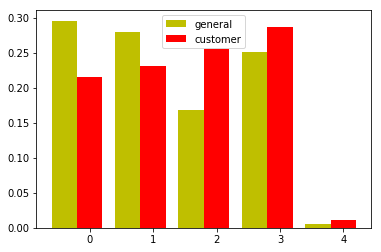

In [52]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
general_propotion= []
customer_propotion = []
for i in range (5):
    general_propotion.append(sum(label == i)/len(label))
    customer_propotion.append(sum(customer_label == i)/len(customer_label))

total_width, n = 0.8, 2  
width = total_width / n  
x =list(range(5))  
plt.bar(x, general_propotion, width=width, label='general',fc = 'y')  
for i in range(len(x)):  
    x[i] = x[i] + width  
plt.bar(x, customer_propotion, width=width, label='customer',tick_label = list(range(5)),fc = 'r')
plt.legend()  
plt.show()  

In [53]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

#first we need to concatenate
customer_label_df = pd.DataFrame(data = customer_label,columns= ['customer_label'])
copy_customers_0 = pd.concat([cleaned_customers, customer_label_df],axis = 1)

In [58]:
cluster_2 = copy_customers_0[copy_customers_0['customer_label'] == 2].dropna()
cluster_2.head()

,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,WOHNLAGE,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,ANREDE_KZ_1,ANREDE_KZ_2,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,FINANZTYP_1,FINANZTYP_2,FINANZTYP_3,FINANZTYP_4,FINANZTYP_5,FINANZTYP_6,GFK_URLAUBERTYP_1.0,GFK_URLAUBERTYP_2.0,GFK_URLAUBERTYP_3.0,GFK_URLAUBERTYP_4.0,GFK_URLAUBERTYP_5.0,GFK_URLAUBERTYP_6.0,GFK_URLAUBERTYP_7.0,GFK_URLAUBERTYP_8.0,GFK_URLAUBERTYP_9.0,GFK_URLAUBERTYP_10.0,GFK_URLAUBERTYP_11.0,GFK_URLAUBERTYP_12.0,GREEN_AVANTGARDE_0,GREEN_AVANTGARDE_1,LP_FAMILIE_FEIN_1.0,LP_FAMILIE_FEIN_2.0,LP_FAMILIE_FEIN_3.0,LP_FAMILIE_FEIN_4.0,LP_FAMILIE_FEIN_5.0,LP_FAMILIE_FEIN_6.0,LP_FAMILIE_FEIN_7.0,LP_FAMILIE_FEIN_8.0,LP_FAMILIE_FEIN_9.0,LP_FAMILIE_FEIN_10.0,LP_FAMILIE_FEIN_11.0,LP_FAMILIE_GROB_1.0,LP_FAMILIE_GROB_2.0,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0,LP_STATUS_FEIN_1.0,LP_STATUS_FEIN_2.0,LP_STATUS_FEIN_3.0,LP_STATUS_FEIN_4.0,LP_STATUS_FEIN_5.0,LP_STATUS_FEIN_6.0,LP_STATUS_FEIN_7.0,LP_STATUS_FEIN_8.0,LP_STATUS_FEIN_9.0,LP_STATUS_FEIN_10.0,LP_STATUS_GROB_1.0,LP_STATUS_GROB_2.0,LP_STATUS_GROB_3.0,LP_STATUS_GROB_4.0,LP_STATUS_GROB_5.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,SOHO_KZ_0.0,SOHO_KZ_1.0,VERS_TYP_1.0,VERS_TYP_2.0,ZABEOTYP_1,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6,GEBAEUDETYP_1.0,GEBAEUDETYP_2.0,GEBAEUDETYP_3.0,GEBAEUDETYP_4.0,GEBAEUDETYP_6.0,GEBAEUDETYP_8.0,OST_WEST_KZ_0,OST_WEST_KZ_1,CAMEO_DEUG_2015_4.0,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,CAMEO_DEU_2015_0,CAMEO_DEU_2015_1,CAMEO_DEU_2015_2,CAMEO_DEU_2015_3,CAMEO_DEU_2015_4,CAMEO_DEU_2015_5,CAMEO_DEU_2015_6,CAMEO_DEU_2015_7,CAMEO_DEU_2015_8,CAMEO_DEU_2015_9,CAMEO_DEU_2015_10,CAMEO_DEU_2015_11,CAMEO_DEU_2015_12,CAMEO_DEU_2015_13,CAMEO_DEU_2015_14,CAMEO_DEU_2015_15,CAMEO_DEU_2015_16,CAMEO_DEU_2015_17,CAMEO_DEU_2015_18,CAMEO_DEU_2015_19,CAMEO_DEU_2015_20,CAMEO_DEU_2015_21,CAMEO_DEU_2015_22,CAMEO_DEU_2015_23,CAMEO_DEU_2015_24,CAMEO_DEU_2015_25,CAMEO_DEU_2015_26,CAMEO_DEU_2015_27,CAMEO_DEU_2015_28,CAMEO_DEU_2015_29,CAMEO_DEU_2015_30,CAMEO_DEU_2015_31,CAMEO_DEU_2015_32,CAMEO_DEU_2015_33,CAMEO_DEU_2015_34,CAMEO_DEU_2015_35,CAMEO_DEU_2015_36,CAMEO_DEU_2015_37,CAMEO_DEU_2015_38,CAMEO_DEU_2015_39,CAMEO_DEU_2015_40,CAMEO_DEU_2015_41,CAMEO_DEU_2015_42,CAMEO_DEU_2015_43,CAMEO_DEU_2015_44,wealth,life_step,CAMEO_DEU_2015_0,CAMEO_DEU_2015_1,CAMEO_DEU_2015_2,CAMEO_DEU_2015_3,CAMEO_DEU_2015_0,CAMEO_DEU_2015_1,CAMEO_DEU_2015_2,CAMEO_DEU_2015_3,CAMEO_DEU_2015_4,customer_label
5,3.0,5.0,1.0,5.0,1.0,2.0,3.0,3.0,16.0,4.0,3.0,6.0,4.0,4.0,1.0,7.0,6.0,4.0,6.0,2.0,5.0,5.0,3.0,3.0,4.0,2.0,0.0,1.0,6.0,9.0,1.0,0.0,2.0,1992.0,1.0,2.0,2.0,1.0,0.0,3.0,7.0,5.0,8.0,4.0,2.0,3.0,3.0,3.0,1167.0,2.0,3.0,2.0,1.0,0.0,5.0,5.0,3.0,7.0,5.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,

In [59]:
for name, col in cluster_2.iteritems():
    print( col.value_counts())

4.0    15104
3.0     8197
2.0      768
1.0      617
Name: ALTERSKATEGORIE_GROB, dtype: int64
5.0    14405
4.0     4973
3.0     3355
2.0     1698
1.0      255
Name: FINANZ_MINIMALIST, dtype: int64
1.0    18413
2.0     3931
3.0     1445
4.0      630
5.0      267
Name: FINANZ_SPARER, dtype: int64
5.0    18278
4.0     4263
3.0     1191
2.0      516
1.0      438
Name: FINANZ_VORSORGER, dtype: int64
1.0    16855
2.0     4227
3.0     2005
4.0     1102
5.0      497
Name: FINANZ_ANLEGER, dtype: int64
1.0    11279
2.0     9057
3.0     2997
4.0      734
5.0      619
Name: FINANZ_UNAUFFAELLIGER, dtype: int64
2.0    9424
3.0    4522
5.0    3819
1.0    3577
4.0    3344
Name: FINANZ_HAUSBAUER, dtype: int64
2.0    10227
1.0     7806
3.0     6653
Name: HEALTH_TYP, dtype: int64
39.0    3469
19.0    2079
12.0    1922
35.0    1621
37.0    1440
38.0    1195
7.0     1167
5.0     1149
18.0     995
11.0     991
31.0     931
36.0     716
30.0     712
15.0     705
16.0     647
14.0     586
27.0     533
8.0     

- After Looking at the counts of every columns in cluster_0, I found that customers that are over-represented usually middle age who have low-income,have average Financial typology.They have length of residence more than 10 years in west with average neiborhood.Besides, they have less affluent household and are pre family, couples or single.

In [60]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

cluster_0 = copy_customers_0[copy_customers_0['customer_label'] == 0].dropna()
cluster_0.head()

,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,WOHNLAGE,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,ANREDE_KZ_1,ANREDE_KZ_2,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,FINANZTYP_1,FINANZTYP_2,FINANZTYP_3,FINANZTYP_4,FINANZTYP_5,FINANZTYP_6,GFK_URLAUBERTYP_1.0,GFK_URLAUBERTYP_2.0,GFK_URLAUBERTYP_3.0,GFK_URLAUBERTYP_4.0,GFK_URLAUBERTYP_5.0,GFK_URLAUBERTYP_6.0,GFK_URLAUBERTYP_7.0,GFK_URLAUBERTYP_8.0,GFK_URLAUBERTYP_9.0,GFK_URLAUBERTYP_10.0,GFK_URLAUBERTYP_11.0,GFK_URLAUBERTYP_12.0,GREEN_AVANTGARDE_0,GREEN_AVANTGARDE_1,LP_FAMILIE_FEIN_1.0,LP_FAMILIE_FEIN_2.0,LP_FAMILIE_FEIN_3.0,LP_FAMILIE_FEIN_4.0,LP_FAMILIE_FEIN_5.0,LP_FAMILIE_FEIN_6.0,LP_FAMILIE_FEIN_7.0,LP_FAMILIE_FEIN_8.0,LP_FAMILIE_FEIN_9.0,LP_FAMILIE_FEIN_10.0,LP_FAMILIE_FEIN_11.0,LP_FAMILIE_GROB_1.0,LP_FAMILIE_GROB_2.0,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0,LP_STATUS_FEIN_1.0,LP_STATUS_FEIN_2.0,LP_STATUS_FEIN_3.0,LP_STATUS_FEIN_4.0,LP_STATUS_FEIN_5.0,LP_STATUS_FEIN_6.0,LP_STATUS_FEIN_7.0,LP_STATUS_FEIN_8.0,LP_STATUS_FEIN_9.0,LP_STATUS_FEIN_10.0,LP_STATUS_GROB_1.0,LP_STATUS_GROB_2.0,LP_STATUS_GROB_3.0,LP_STATUS_GROB_4.0,LP_STATUS_GROB_5.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,SOHO_KZ_0.0,SOHO_KZ_1.0,VERS_TYP_1.0,VERS_TYP_2.0,ZABEOTYP_1,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6,GEBAEUDETYP_1.0,GEBAEUDETYP_2.0,GEBAEUDETYP_3.0,GEBAEUDETYP_4.0,GEBAEUDETYP_6.0,GEBAEUDETYP_8.0,OST_WEST_KZ_0,OST_WEST_KZ_1,CAMEO_DEUG_2015_4.0,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,CAMEO_DEU_2015_0,CAMEO_DEU_2015_1,CAMEO_DEU_2015_2,CAMEO_DEU_2015_3,CAMEO_DEU_2015_4,CAMEO_DEU_2015_5,CAMEO_DEU_2015_6,CAMEO_DEU_2015_7,CAMEO_DEU_2015_8,CAMEO_DEU_2015_9,CAMEO_DEU_2015_10,CAMEO_DEU_2015_11,CAMEO_DEU_2015_12,CAMEO_DEU_2015_13,CAMEO_DEU_2015_14,CAMEO_DEU_2015_15,CAMEO_DEU_2015_16,CAMEO_DEU_2015_17,CAMEO_DEU_2015_18,CAMEO_DEU_2015_19,CAMEO_DEU_2015_20,CAMEO_DEU_2015_21,CAMEO_DEU_2015_22,CAMEO_DEU_2015_23,CAMEO_DEU_2015_24,CAMEO_DEU_2015_25,CAMEO_DEU_2015_26,CAMEO_DEU_2015_27,CAMEO_DEU_2015_28,CAMEO_DEU_2015_29,CAMEO_DEU_2015_30,CAMEO_DEU_2015_31,CAMEO_DEU_2015_32,CAMEO_DEU_2015_33,CAMEO_DEU_2015_34,CAMEO_DEU_2015_35,CAMEO_DEU_2015_36,CAMEO_DEU_2015_37,CAMEO_DEU_2015_38,CAMEO_DEU_2015_39,CAMEO_DEU_2015_40,CAMEO_DEU_2015_41,CAMEO_DEU_2015_42,CAMEO_DEU_2015_43,CAMEO_DEU_2015_44,wealth,life_step,CAMEO_DEU_2015_0,CAMEO_DEU_2015_1,CAMEO_DEU_2015_2,CAMEO_DEU_2015_3,CAMEO_DEU_2015_0,CAMEO_DEU_2015_1,CAMEO_DEU_2015_2,CAMEO_DEU_2015_3,CAMEO_DEU_2015_4,customer_label
2,4.0,5.0,1.0,5.0,1.0,4.0,4.0,2.0,12.0,2.0,5.0,2.0,2.0,1.0,3.0,3.0,7.0,7.0,1.0,2.0,7.0,5.0,6.0,4.0,1.0,1.0,0.0,1.0,6.0,9.0,1.0,0.0,1.0,1992.0,2.0,2.0,2.0,0.0,0.0,3.0,7.0,4.0,1.0,3.0,3.0,3.0,1.0,7.0,433.0,2.0,3.0,3.0,1.0,2.0,3.0,2.0,3.0,5.0,3.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0

In [61]:
for name, col in cluster_0.iteritems():
    print( col.value_counts())

4.0    12743
3.0     6990
2.0      681
1.0      486
Name: ALTERSKATEGORIE_GROB, dtype: int64
5.0    12249
4.0     4099
3.0     2945
2.0     1403
1.0      204
Name: FINANZ_MINIMALIST, dtype: int64
1.0    15649
2.0     3249
3.0     1281
4.0      484
5.0      237
Name: FINANZ_SPARER, dtype: int64
5.0    15486
4.0     3604
3.0     1006
2.0      416
1.0      388
Name: FINANZ_VORSORGER, dtype: int64
1.0    14188
2.0     3617
3.0     1670
4.0     1033
5.0      392
Name: FINANZ_ANLEGER, dtype: int64
1.0    9538
2.0    7690
3.0    2619
4.0     566
5.0     487
Name: FINANZ_UNAUFFAELLIGER, dtype: int64
2.0    8038
3.0    3722
5.0    3274
1.0    3029
4.0    2837
Name: FINANZ_HAUSBAUER, dtype: int64
2.0    8682
1.0    6548
3.0    5670
Name: HEALTH_TYP, dtype: int64
39.0    2946
19.0    1708
12.0    1541
37.0    1386
35.0    1283
38.0    1035
5.0     1004
7.0      889
11.0     879
18.0     840
31.0     793
30.0     635
36.0     609
15.0     589
16.0     555
14.0     518
27.0     462
8.0      432
4.0

- In contrast, customers in cluster_2 that are under-represented are mostly top-earners of middle age from multiperson household ,their social status  are typical average-income earners.Their building location are in the west with average neighborhood.

### Discussion 3.3: Compare Customer Data to Demographics Data

- After Looking at the counts of every columns in cluster_1, I found that customers that are over-represented usually are low-earners living in shared flat, multi/two-generational household.They usually lived in east and have poor neiborhood.Besides, they have poorer household and are pre family, couples or single.
- In contrast, customers in cluster_2 that are under-represented are mostly single low-income earner of advance age ,their social status are typical low-income earners.Their building location are in the west with average neighborhood.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.